In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os

train_dir = '/content/drive/MyDrive/Fish_Images/data/train'

if os.path.exists(train_dir):
    print("The dataset directory exists.")
    print("Classes (Folders):", os.listdir(train_dir))
else:
    print("❌ The directory does NOT exist. Check the path!")

The dataset directory exists.
Classes (Folders): ['fish sea_food striped_red_mullet', 'fish sea_food red_mullet', 'fish sea_food shrimp', 'fish sea_food trout', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'animal fish', 'animal fish bass']


In [2]:
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # or 'categorical' if needed
)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 6235 files belonging to 11 classes.
Class Names: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [3]:
# Apply Rescaling ONLY once
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [4]:
for images, labels in train_dataset.take(1):
    print("Image dtype:", images.dtype)
    print("Min pixel:", tf.reduce_min(images).numpy())
    print("Max pixel:", tf.reduce_max(images).numpy())

Image dtype: <dtype: 'float32'>
Min pixel: 0.0
Max pixel: 1.0


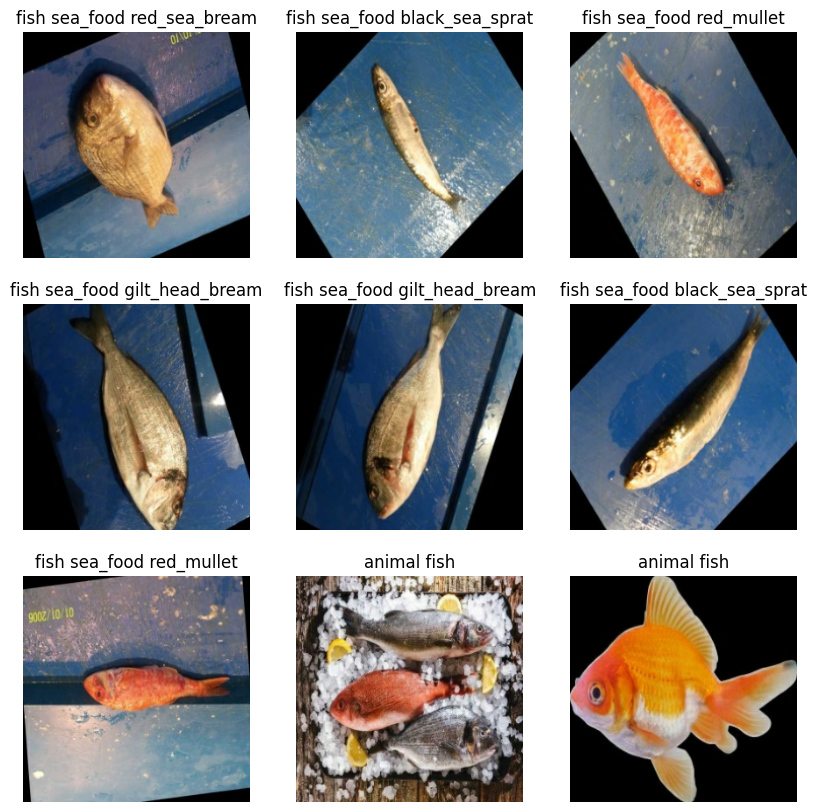

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Add Data Augmentation


In [6]:
from tensorflow.keras import layers

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),          # Flip images horizontally
    layers.RandomRotation(0.1),               # Rotate images randomly by 10%
    layers.RandomZoom(0.1),                   # Zoom images randomly
])

# Apply data augmentation to the training dataset
augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
train_dir = "/content/drive/MyDrive/Fish_Images/data/train"
val_dir = "/content/drive/MyDrive/Fish_Images/data/val"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Save class names
class_names = train_dataset.class_names

Found 6235 files belonging to 11 classes.
Found 1092 files belonging to 11 classes.


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_vgg16_model.h5",monitor = 'val_loss', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.1621 - loss: 2.3946 

195/195 ━━━━━━━━━━━━━━━━━━━━ 4214s 22s/step - accuracy: 0.1624 - loss: 2.3939 - val_accuracy: 0.4350 - val_loss: 1.9563
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3388 - loss: 1.9416 

195/195 ━━━━━━━━━━━━━━━━━━━━ 4131s 21s/step - accuracy: 0.3390 - loss: 1.9412 - val_accuracy: 0.5788 - val_loss: 1.7157
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4694 - loss: 1.6888 

195/195 ━━━━━━━━━━━━━━━━━━━━ 4180s 21s/step - accuracy: 0.4696 - loss: 1.6886 - val_accuracy: 0.6484 - val_loss: 1.5343
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5700 - loss: 1.5070 

195/195 ━━━━━━━━━━━━━━━━━━━━ 4165s 21s/step - accuracy: 0.5700 - loss: 1.5069 - val_accuracy: 0.6905 - val_loss: 1.3801
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6262 - loss: 1.3572 

195/195 ━━━━━━━━━━━━━━━━━━━━ 4113s 21s/step - accuracy: 0.6262 - loss: 1.3571 - val_accuracy: 0.7326 - val_loss: 1.2447
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6652 - loss: 1.2425 

In [ ]:
import os

print("File Exsists:", os.path.exists("vgg16_fish_model.h5"))

File Exsists: False


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_dir = '/content/drive/MyDrive/Fish_Models'
os.makedirs(save_dir, exist_ok=True)

# Load VGG16 base model (pretrained on ImageNet)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'vgg16_fish_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

# Save final model explicitly
model.save(os.path.join(save_dir, 'final_vgg16_model.h5'))

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'class_names' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Fish_Models/vgg16_fish_model.h5')

# Evaluate
loss, acc = model.evaluate(val_ds)
print(f"✅ Final VGG16 Model - Val Accuracy: {acc:.4f}, Val Loss: {loss:.4f}")

17/35 ━━━━━━━━━━━━━━━━━━━━ 6:11 21s/step - accuracy: 0.8179 - loss: 0.9271

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_dir = '/content/drive/MyDrive/Fish_Models'
os.makedirs(save_dir, exist_ok=True)

# List of pretrained models to train
models_dict = {
    "ResNet50": ResNet50,
    "MobileNet": MobileNet,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}

best_accuracy = 0
best_model_name = ""
best_model = None

for model_name, model_fn in models_dict.items():
    print(f"\n🚀 Training {model_name}...")

    base_model = model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint_path = os.path.join(save_dir, f'{model_name.lower()}_fish_model.h5')
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, checkpoint]
    )

    val_loss, val_accuracy = model.evaluate(val_ds)
    print(f"\n✅ {model_name} - Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_name = model_name
        best_model = model

# Save the best model explicitly
if best_model:
    final_path = os.path.join(save_dir, f'best_fish_model_{best_model_name}.h5')
    best_model.save(final_path)
    print(f"\n🎯 Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
    print(f"📁 Saved as: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 Training ResNet50...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1222 - loss: 2.5345
Epoch 1: val_loss improved from inf to 2.26534, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1490s 8s/step - accuracy: 0.1224 - loss: 2.5340 - val_accuracy: 0.1712 - val_loss: 2.2653
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1806 - loss: 2.2824
Epoch 2: val_loss improved from 2.26534 to 2.22325, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1484s 7s/step - accuracy: 0.1806 - loss: 2.2823 - val_accuracy: 0.1712 - val_loss: 2.2232
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1918 - loss: 2.2386
Epoch 3: val_loss improved from 2.22325 to 2.19108, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1451s 7s/step - accuracy: 0.1919 - loss: 2.2385 - val_accuracy: 0.1685 - val_loss: 2.1911
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2021 - loss: 2.1951
Epoch 4: val_loss improved from 2.19108 to 2.16018, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1465s 7s/step - accuracy: 0.2021 - loss: 2.1951 - val_accuracy: 0.1740 - val_loss: 2.1602
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2238 - loss: 2.1653
Epoch 5: val_loss improved from 2.16018 to 2.13243, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1362s 7s/step - accuracy: 0.2238 - loss: 2.1653 - val_accuracy: 0.1969 - val_loss: 2.1324
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2233 - loss: 2.1362
Epoch 6: val_loss improved from 2.13243 to 2.10689, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1474s 7s/step - accuracy: 0.2233 - loss: 2.1361 - val_accuracy: 0.2070 - val_loss: 2.1069
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2403 - loss: 2.1040
Epoch 7: val_loss improved from 2.10689 to 2.08214, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1414s 7s/step - accuracy: 0.2403 - loss: 2.1040 - val_accuracy: 0.2546 - val_loss: 2.0821
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2626 - loss: 2.0860
Epoch 8: val_loss improved from 2.08214 to 2.05597, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1398s 7s/step - accuracy: 0.2625 - loss: 2.0860 - val_accuracy: 0.2555 - val_loss: 2.0560
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2673 - loss: 2.0583
Epoch 9: val_loss improved from 2.05597 to 2.03413, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1433s 7s/step - accuracy: 0.2673 - loss: 2.0583 - val_accuracy: 0.2821 - val_loss: 2.0341
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2785 - loss: 2.0323
Epoch 10: val_loss improved from 2.03413 to 2.01031, saving model to /content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1462s 7s/step - accuracy: 0.2785 - loss: 2.0322 - val_accuracy: 0.3132 - val_loss: 2.0103
35/35 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.3293 - loss: 1.9961

✅ ResNet50 - Val Accuracy: 0.3132, Val Loss: 2.0103

🚀 Training MobileNet...
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3544 - loss: 2.0317
Epoch 1: val_loss improved from inf to 0.56387, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.3554 - loss: 2.0285 - val_accuracy: 0.9093 - val_loss: 0.5639
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8254 - loss: 0.6218
Epoch 2: val_loss improved from 0.56387 to 0.26342, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.8255 - loss: 0.6214 - val_accuracy: 0.9597 - val_loss: 0.2634
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9155 - loss: 0.3385
Epoch 3: val_loss improved from 0.26342 to 0.16177, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9155 - loss: 0.3384 - val_accuracy: 0.9734 - val_loss: 0.1618
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - loss: 0.2133
Epoch 4: val_loss improved from 0.16177 to 0.10619, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9452 - loss: 0.2133 - val_accuracy: 0.9808 - val_loss: 0.1062
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9594 - loss: 0.1626
Epoch 5: val_loss improved from 0.10619 to 0.07859, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9594 - loss: 0.1625 - val_accuracy: 0.9881 - val_loss: 0.0786
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9698 - loss: 0.1266
Epoch 6: val_loss improved from 0.07859 to 0.06359, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9698 - loss: 0.1265 - val_accuracy: 0.9908 - val_loss: 0.0636
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9771 - loss: 0.1053
Epoch 7: val_loss improved from 0.06359 to 0.05194, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9771 - loss: 0.1053 - val_accuracy: 0.9918 - val_loss: 0.0519
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9816 - loss: 0.0832
Epoch 8: val_loss improved from 0.05194 to 0.04437, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9816 - loss: 0.0832 - val_accuracy: 0.9927 - val_loss: 0.0444
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9811 - loss: 0.0745
Epoch 9: val_loss improved from 0.04437 to 0.03542, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9812 - loss: 0.0744 - val_accuracy: 0.9945 - val_loss: 0.0354
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9862 - loss: 0.0593
Epoch 10: val_loss improved from 0.03542 to 0.03499, saving model to /content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9862 - loss: 0.0593 - val_accuracy: 0.9945 - val_loss: 0.0350
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9936 - loss: 0.0370

✅ MobileNet - Val Accuracy: 0.9945, Val Loss: 0.0350

🚀 Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4422 - loss: 1.7628
Epoch 1: val_loss improved from inf to 0.46851, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 942s 5s/step - accuracy: 0.4431 - loss: 1.7600 - val_accuracy: 0.8947 - val_loss: 0.4685
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8492 - loss: 0.5087
Epoch 2: val_loss improved from 0.46851 to 0.25820, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 996s 5s/step - accuracy: 0.8493 - loss: 0.5084 - val_accuracy: 0.9423 - val_loss: 0.2582
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9074 - loss: 0.3243
Epoch 3: val_loss improved from 0.25820 to 0.19703, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 977s 5s/step - accuracy: 0.9074 - loss: 0.3242 - val_accuracy: 0.9551 - val_loss: 0.1970
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9256 - loss: 0.2437
Epoch 4: val_loss improved from 0.19703 to 0.14762, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 939s 5s/step - accuracy: 0.9256 - loss: 0.2436 - val_accuracy: 0.9698 - val_loss: 0.1476
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9472 - loss: 0.1923
Epoch 5: val_loss improved from 0.14762 to 0.12614, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 948s 5s/step - accuracy: 0.9472 - loss: 0.1922 - val_accuracy: 0.9679 - val_loss: 0.1261
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9585 - loss: 0.1538
Epoch 6: val_loss improved from 0.12614 to 0.10322, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 949s 5s/step - accuracy: 0.9585 - loss: 0.1537 - val_accuracy: 0.9789 - val_loss: 0.1032
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9676 - loss: 0.1214
Epoch 7: val_loss improved from 0.10322 to 0.09070, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 944s 5s/step - accuracy: 0.9676 - loss: 0.1214 - val_accuracy: 0.9771 - val_loss: 0.0907
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9687 - loss: 0.1080
Epoch 8: val_loss improved from 0.09070 to 0.07822, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 985s 5s/step - accuracy: 0.9687 - loss: 0.1079 - val_accuracy: 0.9789 - val_loss: 0.0782
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9781 - loss: 0.0855
Epoch 9: val_loss improved from 0.07822 to 0.07459, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 950s 5s/step - accuracy: 0.9781 - loss: 0.0855 - val_accuracy: 0.9808 - val_loss: 0.0746
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9807 - loss: 0.0811
Epoch 10: val_loss improved from 0.07459 to 0.06939, saving model to /content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 949s 5s/step - accuracy: 0.9807 - loss: 0.0810 - val_accuracy: 0.9817 - val_loss: 0.0694
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9829 - loss: 0.0700

✅ InceptionV3 - Val Accuracy: 0.9817, Val Loss: 0.0694

🚀 Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1454 - loss: 2.3486
Epoch 1: val_loss improved from inf to 2.31597, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.1454 - loss: 2.3486 - val_accuracy: 0.1712 - val_loss: 2.3160
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1719 - loss: 2.3191
Epoch 2: val_loss improved from 2.31597 to 2.31257, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.1719 - loss: 2.3191 - val_accuracy: 0.1712 - val_loss: 2.3126
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1710 - loss: 2.3213
Epoch 3: val_loss improved from 2.31257 to 2.31129, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.1710 - loss: 2.3213 - val_accuracy: 0.1712 - val_loss: 2.3113
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1717 - loss: 2.3186
Epoch 4: val_loss improved from 2.31129 to 2.31056, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.1717 - loss: 2.3186 - val_accuracy: 0.1712 - val_loss: 2.3106
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1740 - loss: 2.3146
Epoch 5: val_loss did not improve from 2.31056
195/195 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.1740 - loss: 2.3146 - val_accuracy: 0.1712 - val_loss: 2.3116
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1741 - loss: 2.3106
Epoch 6: val_loss improved from 2.31056 to 2.30927, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.1741 - loss: 2.3106 - val_accuracy: 0.1712 - val_loss: 2.3093
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1769 - loss: 2.3121
Epoch 7: val_loss did not improve from 2.30927
195/195 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.1769 - loss: 2.3121 - val_accuracy: 0.1712 - val_loss: 2.3106
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1726 - loss: 2.3171
Epoch 8: val_loss did not improve from 2.30927
195/195 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.1726 - loss: 2.3171 - val_accuracy: 0.1712 - val_loss: 2.3115
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1767 - loss: 2.3064
Epoch 9: val_loss improved from 2.30927 to 2.30884, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.1767 - loss: 2.3064 - val_accuracy: 0.1712 - val_loss: 2.3088
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1753 - loss: 2.3076
Epoch 10: val_loss improved from 2.30884 to 2.30859, saving model to /content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 641s 3s/step - accuracy: 0.1753 - loss: 2.3076 - val_accuracy: 0.1712 - val_loss: 2.3086
35/35 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1731 - loss: 2.3024



✅ EfficientNetB0 - Val Accuracy: 0.1712, Val Loss: 2.3086

🎯 Best Model: MobileNet with Accuracy: 0.9945
📁 Saved as: /content/drive/MyDrive/Fish_Models/best_fish_model_MobileNet.h5



Evaluating MobileNet...


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

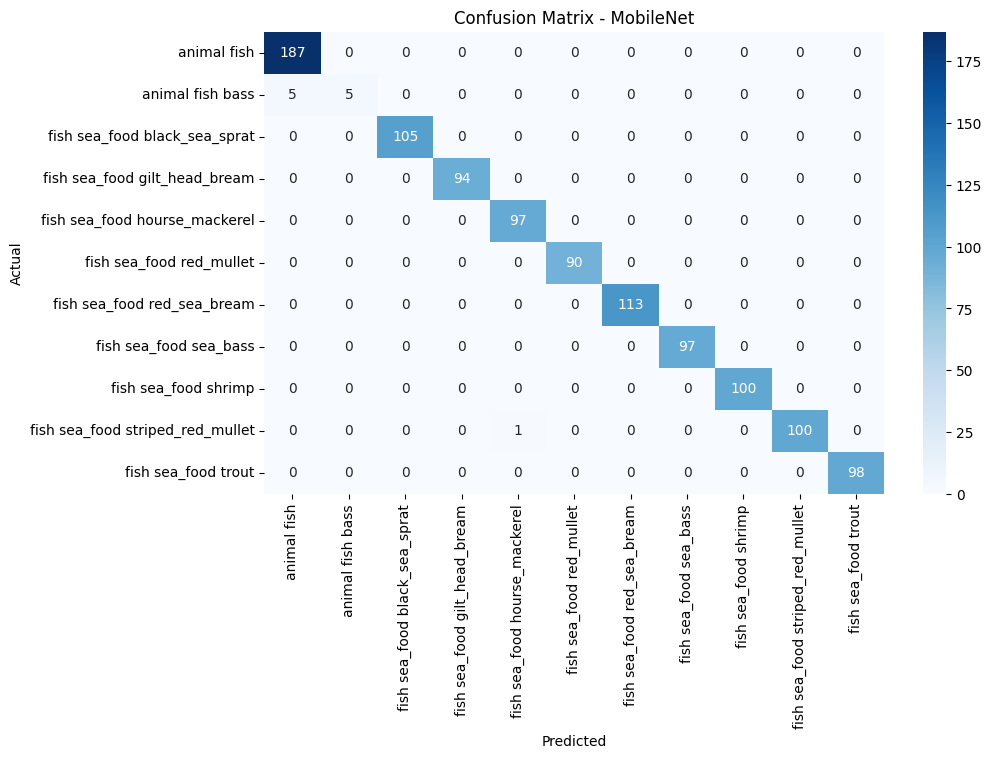


Evaluating InceptionV3...


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

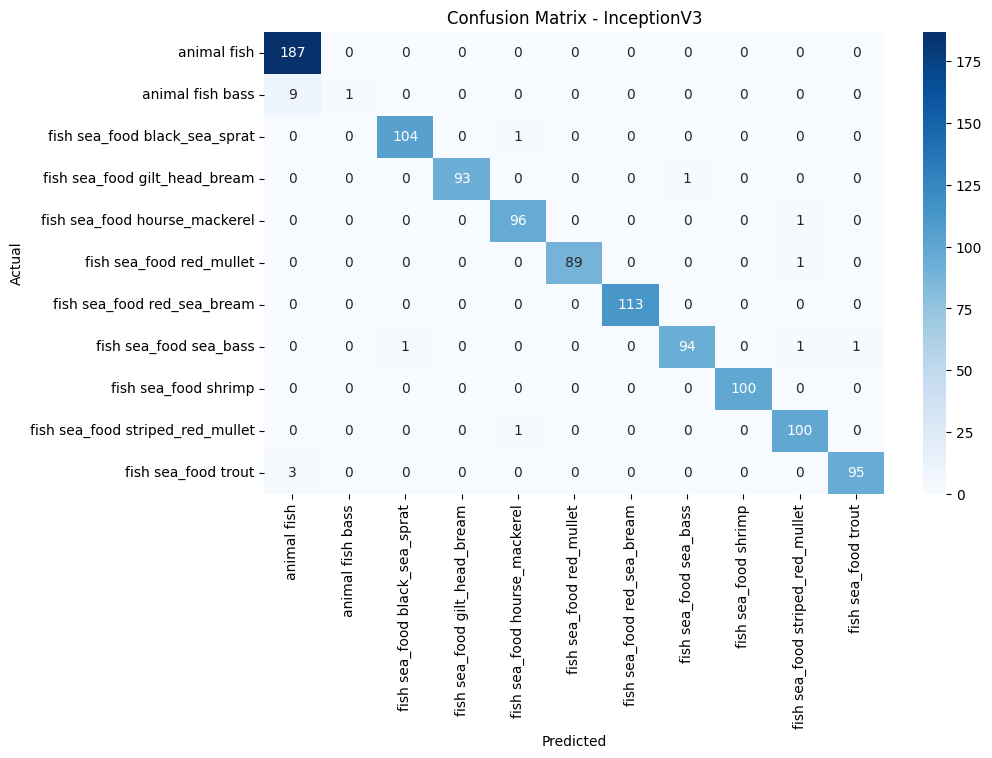


Evaluating ResNet50...


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


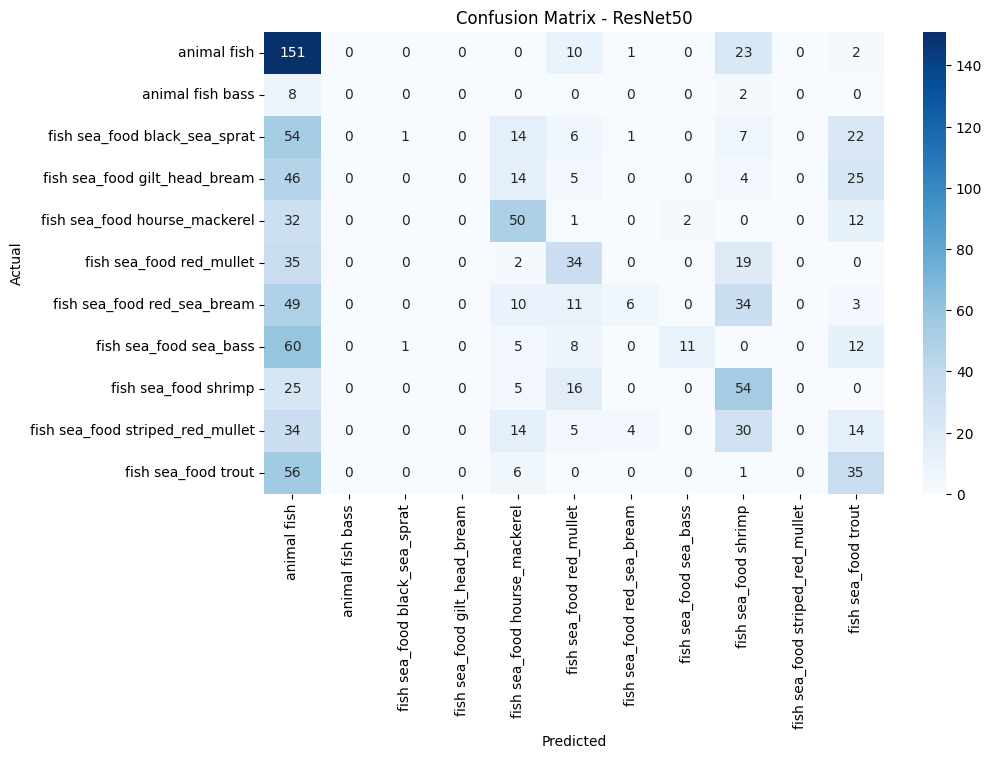


Evaluating EfficientNetB0...


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


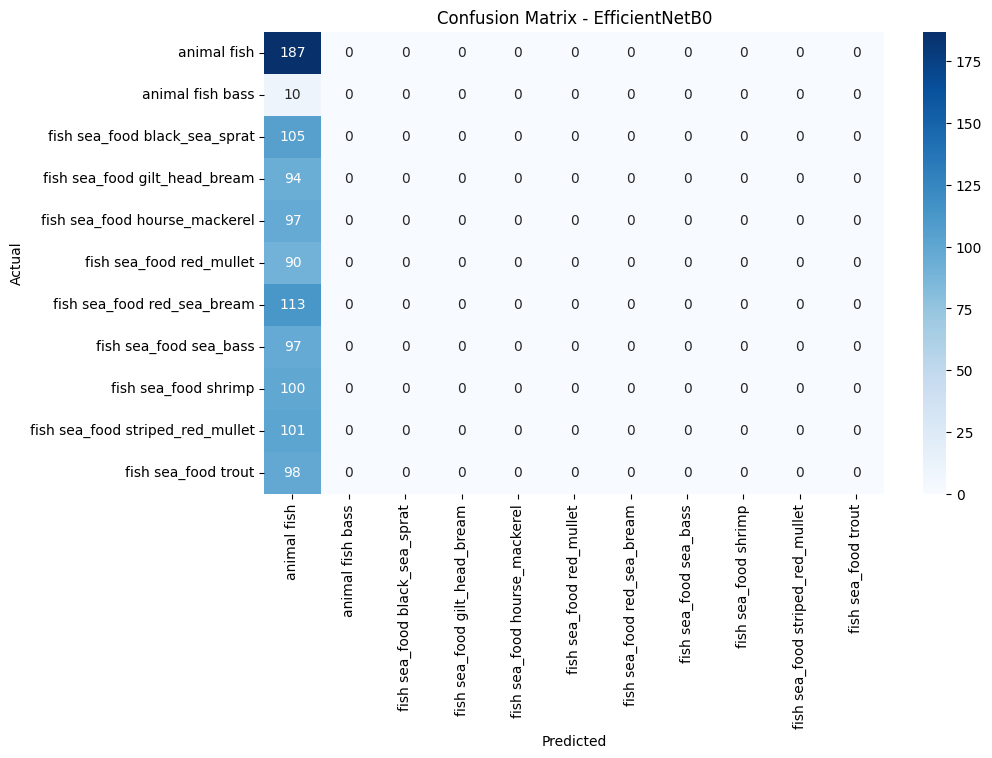


Evaluating VGG16...


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


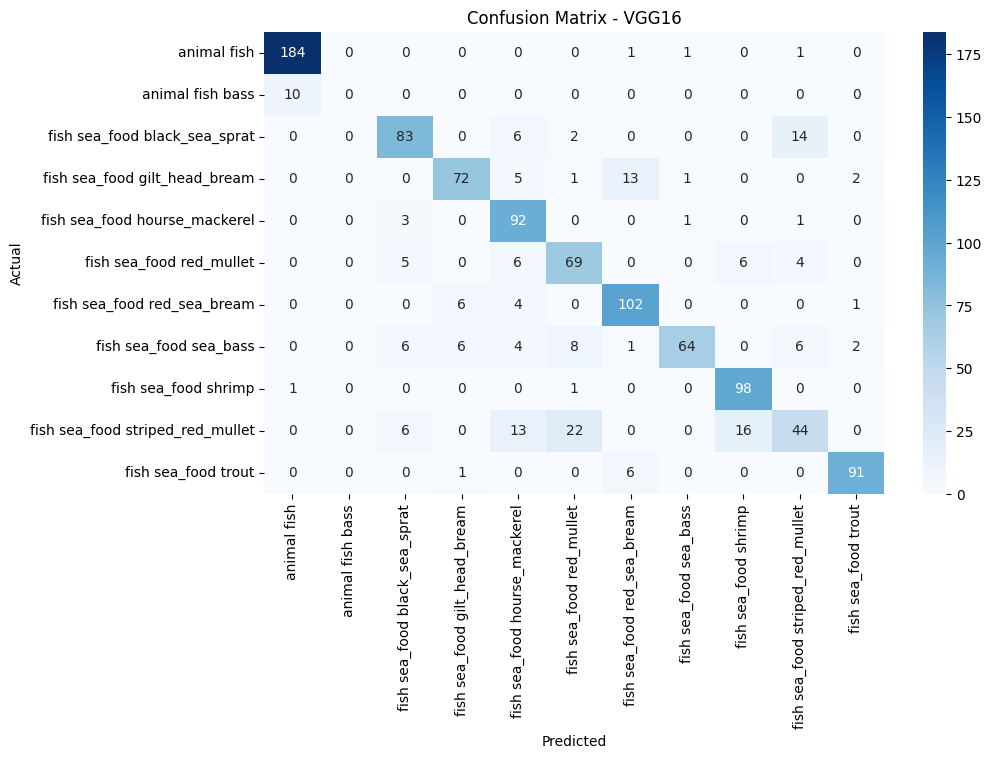


📊 Model Evaluation Summary:
                accuracy precision    recall  f1_score
MobileNet       0.994505  0.996705  0.953645  0.967579
InceptionV3     0.981685  0.987245  0.907907  0.913984
ResNet50        0.313187  0.316534  0.252172  0.205359
EfficientNetB0  0.171245  0.015568  0.090909  0.026583
VGG16            0.82326  0.741065  0.742016  0.734551


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Define model paths
model_paths = {
    "MobileNet": "/content/drive/MyDrive/Fish_Models/mobilenet_fish_model.h5",
    "InceptionV3": "/content/drive/MyDrive/Fish_Models/inceptionv3_fish_model.h5",
    "ResNet50": "/content/drive/MyDrive/Fish_Models/resnet50_fish_model.h5",
    "EfficientNetB0": "/content/drive/MyDrive/Fish_Models/efficientnetb0_fish_model.h5",
    "VGG16": "/content/drive/MyDrive/Fish_Models/vgg16_fish_model.h5"
}

results = {}

for name, path in model_paths.items():
    print(f"\nEvaluating {name}...")
    model = load_model(path)
    y_true, y_pred = [], []

    for batch_images, batch_labels in val_ds:
        preds = model.predict(batch_images)
        y_true.extend(batch_labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    results[name] = {
        'accuracy': report['accuracy'],
        'precision': np.mean([v['precision'] for k, v in report.items() if k in class_names]),
        'recall': np.mean([v['recall'] for k, v in report.items() if k in class_names]),
        'f1_score': np.mean([v['f1-score'] for k, v in report.items() if k in class_names]),
        'confusion_matrix': cm
    }

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display overall comparison table
import pandas as pd
metrics_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Summary:")
print(metrics_df[['accuracy', 'precision', 'recall', 'f1_score']])

In [29]:
!pip install streamlit pyngrok -q

In [30]:
from google.colab import drive
drive.mount('/content/drive')

# Example: Path to your trained model
model_path = "/content/drive/MyDrive/Fish_Models/best_fish_model_MobileNet.h5"

# Path where training folders exist
train_dir = "/content/drive/MyDrive/Fish_Images/data/train"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/Fish_Models/best_fish_model_MobileNet.h5")

# Load class names from actual folders
train_dir = "/content/drive/MyDrive/Fish_Images/data/train"
class_names = sorted(os.listdir(train_dir))

st.title("🐟 Fish Image Classifier")
st.write("Upload an image and the model will predict the fish category.")

uploaded_file = st.file_uploader("Choose a fish image...", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption='Uploaded Image', use_column_width=True)

    img = image.resize((224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    pred_index = np.argmax(prediction)
    confidence = prediction[pred_index] * 100

    st.subheader(f"🎯 Prediction: **{class_names[pred_index]}**")
    st.markdown(f"🔍 Confidence: **{confidence:.2f}%**")

    st.subheader("📊 All Class Confidence Scores")
    for i in range(len(prediction)):
        label = class_names[i] if i < len(class_names) else f"Class_{i}"
        st.write(f"{label}: {prediction[i]*100:.2f}%")

Writing app.py


In [32]:
# Launch Streamlit in background
!streamlit run app.py &>/content/logs.txt &

In [34]:
# Kill all running ngrok processes
!kill $(ps aux | grep 'ngrok' | awk '{print $2}')

^C


In [35]:
from pyngrok import ngrok

ngrok.set_auth_token("2vr9sv9mIt04hRblYKL5hJmCAlx_4enmZSdMqRiM4x4oq71r1")  # Only needed once
public_url = ngrok.connect(8501)
print(f"✅ Streamlit app is running at: {public_url}")

✅ Streamlit app is running at: NgrokTunnel: "https://64c1-34-106-29-115.ngrok-free.app" -> "http://localhost:8501"
